references:
https://www.kaggle.com/code/vinayak123tyagi/damage-propagation-modeling-for-aircraft-engine

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [7]:
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
           'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

train_data_processed = []
for idx in range(1, 5):
    train_data = pd.read_csv(rf"C:\Users\User\Desktop\CMAPS_turbo_engine_RUL\CMAPSSData\train_FD00{idx}.txt",sep=" ",header=None)
    train_data.drop(columns=[26,27],inplace=True)

    train_data.columns = columns
    train_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)
    train_data['RUL'] =  train_data['time_in_cycles'] / train_data.groupby('unit_number')['time_in_cycles'].transform('max') 

    # train_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)

    train_data_processed.append(train_data)
    print(f"Processed train_FD00{idx}.txt, number of rows: {train_data.shape[0]}")
train_data_processed = pd.concat(train_data_processed, ignore_index=True)

Processed train_FD001.txt, number of rows: 20631
Processed train_FD002.txt, number of rows: 53759
Processed train_FD003.txt, number of rows: 24720
Processed train_FD004.txt, number of rows: 61249


In [8]:
test_data_processed = []

for idx in range(1,5):

    test_data_rul = pd.read_csv(rf"C:\Users\User\Desktop\CMAPS_turbo_engine_RUL\CMAPSSData\RUL_FD00{idx}.txt",sep=" ",header=None)
    test_data = pd.read_csv(rf"C:\Users\User\Desktop\CMAPS_turbo_engine_RUL\CMAPSSData\test_FD00{idx}.txt",sep=" ",header=None)


    test_data.drop(columns=[26,27],inplace=True)
    columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
            'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

    test_data.columns = columns
    test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

    eol = []
    for un in test_data['unit_number'].unique():
        temp_data = test_data[test_data['unit_number'] == un]
        eol_temp = test_data_rul.iloc[un-1].values[0]
        eol_temp_list = [eol_temp for i in range(len(temp_data))]

        eol.extend(eol_temp_list)


    test_data['RUL'] = test_data['time_in_cycles'].values / (test_data.groupby('unit_number')['time_in_cycles'].transform('max').values + eol)  
    # test_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)

    test_data_processed.append(test_data)

    print(f"Processed test_FD00{idx}.txt, number of rows: {test_data.shape[0]}")
test_data_processed = pd.concat(test_data_processed, ignore_index=True)


Processed test_FD001.txt, number of rows: 13096
Processed test_FD002.txt, number of rows: 33991
Processed test_FD003.txt, number of rows: 16596
Processed test_FD004.txt, number of rows: 41214


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
# 1. Dataset class
class RULDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# 2. Neural Network model
class RULCNN2D(nn.Module):
    def __init__(self):
        super(RULCNN2D, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),

            nn.AdaptiveAvgPool2d((1, 1))  # Output: (B, 64, 1, 1)
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),        # (B, 64)
            nn.Linear(64,64),
            nn.LeakyReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        # x: (B, 10, 17)
        x = x.unsqueeze(1)       # → (B, 1, 10, 17)
        x = self.cnn(x)          # → (B, 64, 1, 1)
        x = self.regressor(x)    # → (B, 1)
        return x
    
class RULLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super(RULLSTMModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.bn = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Linear(64, 1)
        )

    def forward(self, x, h0=None, c0=None):  # x: [B, Seq, Features]
        out, (hn, cn) = self.lstm(x)
        out = self.fc(out[:, -1, :])  # [B, 1]
        return out


In [11]:
# Normalize the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features = train_data_processed.drop(columns=['RUL'])
scaled_features = scaler.fit_transform(features)
train_data_processed.loc[:, features.columns] = scaled_features

# Normalize test data using the same scaler
test_features = test_data_processed.drop(columns=['RUL'])
test_scaled_features = scaler.transform(test_features)
test_data_processed.loc[:, test_features.columns] = test_scaled_features

C:\Users\User\AppData\Local\Temp\ipykernel_20172\1275619669.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.43485552 -1.43485552 -1.43485552 ...  1.96860101  1.96860101
  1.96860101]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
C:\Users\User\AppData\Local\Temp\ipykernel_20172\1275619669.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.46438155 -1.45241094 -1.44044032 ...  1.55221385  1.56418447
  1.57615508]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data_processed.loc[:, features.columns] = scaled_features
C:\Users\User\AppData\Local\Temp\ipykernel_20172\1275619669.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error 

In [42]:
from tqdm import tqdm

win_len=10

X_train = []
y_train = []

for unit_number in tqdm(train_data_processed['unit_number'].unique(),leave=False):

    unit_data = train_data_processed[train_data_processed['unit_number'] == unit_number]
  
    for i in range(0, len(unit_data)-win_len+1):
        temp = unit_data.iloc[i:i+win_len]
        x_temp = temp.drop(columns=['unit_number','RUL'])
        y_temp = temp['RUL'].values[-1]
        X_train.append(x_temp.values)
        y_train.append(y_temp)

X_test = []
y_test = []

for unit_number in tqdm(test_data_processed['unit_number'].unique(),leave=False):

    unit_data = test_data_processed[test_data_processed['unit_number'] == unit_number]
  
    for i in range(0, len(unit_data)-win_len+1):
        temp = unit_data.iloc[i:i+win_len]
        x_temp = temp.drop(columns=['unit_number','RUL'])
        y_temp = temp['RUL'].values[-1]
        X_test.append(x_temp.values)
        y_test.append(y_temp)

In [43]:
# 4. Dataset & Dataloader
dataset = RULDataset(X_train,y_train)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Create TEST Dataset and DataLoader
test_dataset = RULDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

win_len = 10 # Number of time steps to consider for each sample
# 5. Training Setup
model = RULCNN2D().to(device)
# model = RULLSTMModel(input_size=17).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

def evaluate_model(model, test_loader):
    # 3. Run inference
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy().reshape(-1, 1))
 
    # 4. Calculate MSE
    preds = np.vstack(all_preds)
    targets = np.vstack(all_targets)
    mse = mean_squared_error(targets, preds)
    return mse

In [44]:
# 6. Training Loop
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass

        optimizer.zero_grad()
        outputs = model(X_batch) 
        loss = criterion(outputs, y_batch.view(-1, 1))  # Reshape y_batch to match output shape (B, 1)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(dataloader):.4f}, Test MSE: {evaluate_model(model, test_loader):.4f}")

Epoch [1/20], Loss: 0.0105, Test MSE: 0.0064
Epoch [2/20], Loss: 0.0059, Test MSE: 0.0077
Epoch [3/20], Loss: 0.0053, Test MSE: 0.0064
Epoch [4/20], Loss: 0.0051, Test MSE: 0.0055
Epoch [5/20], Loss: 0.0049, Test MSE: 0.0055
Epoch [6/20], Loss: 0.0048, Test MSE: 0.0055


KeyboardInterrupt: 

In [45]:
for X_batch, y_batch in dataloader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    break

In [46]:
X_batch.shape

torch.Size([16, 10, 18])

# Visualize Test Results

In [49]:

idx=1

test_data_rul = pd.read_csv(rf"C:\Users\User\Desktop\CMAPS_turbo_engine_RUL\CMAPSSData\RUL_FD00{idx}.txt",sep=" ",header=None)
test_data = pd.read_csv(rf"C:\Users\User\Desktop\CMAPS_turbo_engine_RUL\CMAPSSData\test_FD00{idx}.txt",sep=" ",header=None)


test_data.drop(columns=[26,27],inplace=True)
columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
        'Nc','epr','Ps30','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]

test_data.columns = columns
test_data.drop(columns=['Nf_dmd','PCNfR_dmd','P2','T2','TRA','farB','epr'],inplace=True)

eol = []
for un in test_data['unit_number'].unique():
    temp_data = test_data[test_data['unit_number'] == un]
    eol_temp = test_data_rul.iloc[un-1].values[0]
    eol_temp_list = [eol_temp for i in range(len(temp_data))]

    eol.extend(eol_temp_list)


test_data['RUL'] = test_data['time_in_cycles'].values / (test_data.groupby('unit_number')['time_in_cycles'].transform('max').values + eol) 
# test_data.drop(columns=['unit_number', 'setting_1', 'setting_2'],inplace=True)




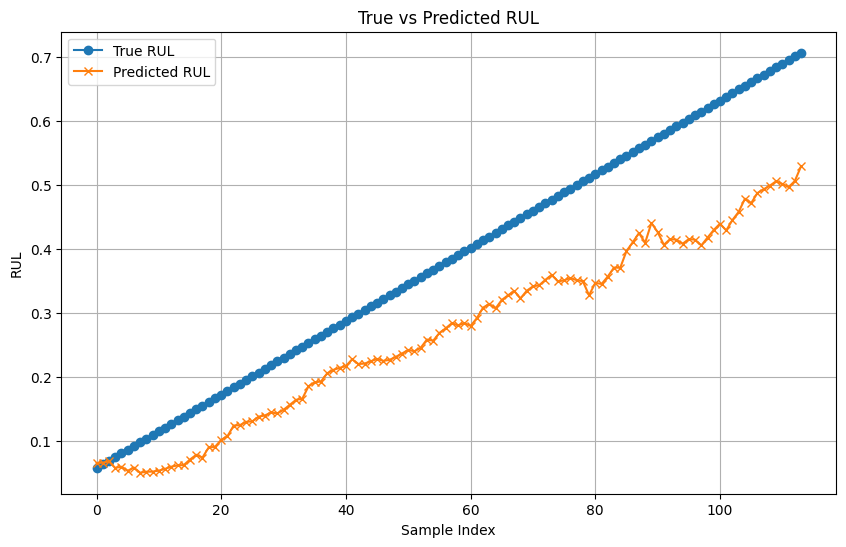

In [52]:
X_test_unit = []
y_test_unit = []

test_unit_no = 9
test_data_per_unit = test_data[test_data['unit_number'] == test_unit_no]

for i in range(0, len(unit_data)-win_len+1):
    temp = unit_data.iloc[i:i+win_len]
    x_temp = temp.drop(columns=['unit_number','RUL'])
    y_temp = temp['RUL'].values[-1]
    X_test_unit.append(x_temp.values)
    y_test_unit.append(y_temp)

# Convert to torch tensor
X_test_tensor = torch.tensor(X_test_unit, dtype=torch.float32)

# Predict without gradient tracking
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor.to('cuda'))

# If y_pred is a tensor, move to CPU and flatten
y_pred = y_pred.cpu().numpy().flatten()

# Plot
plt.figure(figsize=(10,6))
plt.plot(y_test_unit, label='True RUL', marker='o')
plt.plot(y_pred, label='Predicted RUL', marker='x')
plt.title('True vs Predicted RUL')
plt.xlabel('Sample Index')
plt.ylabel('RUL')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
X_test[0].shape,y_test.shape

AttributeError: 'list' object has no attribute 'shape'

In [ ]:


plt.figure(figsize=(8, 5))
plt.plot(unit_data['time_in_cycles'], 1-true_rul, label='True RUL', marker='o')
plt.plot(unit_data['time_in_cycles'], 1-pred_rul, label='Predicted RUL', marker='s')
plt.xlabel('Time in Cycles')
plt.ylabel('Remaining Useful Life (RUL)')
plt.title(f'Predicted vs True RUL for Unit {unit_id}')
plt.legend()
plt.show()

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- setting_1
- setting_2
- unit_number
